<a href="https://colab.research.google.com/github/HarshalAH/MAE_598-Design_Optimisation/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] loss: 14153.558


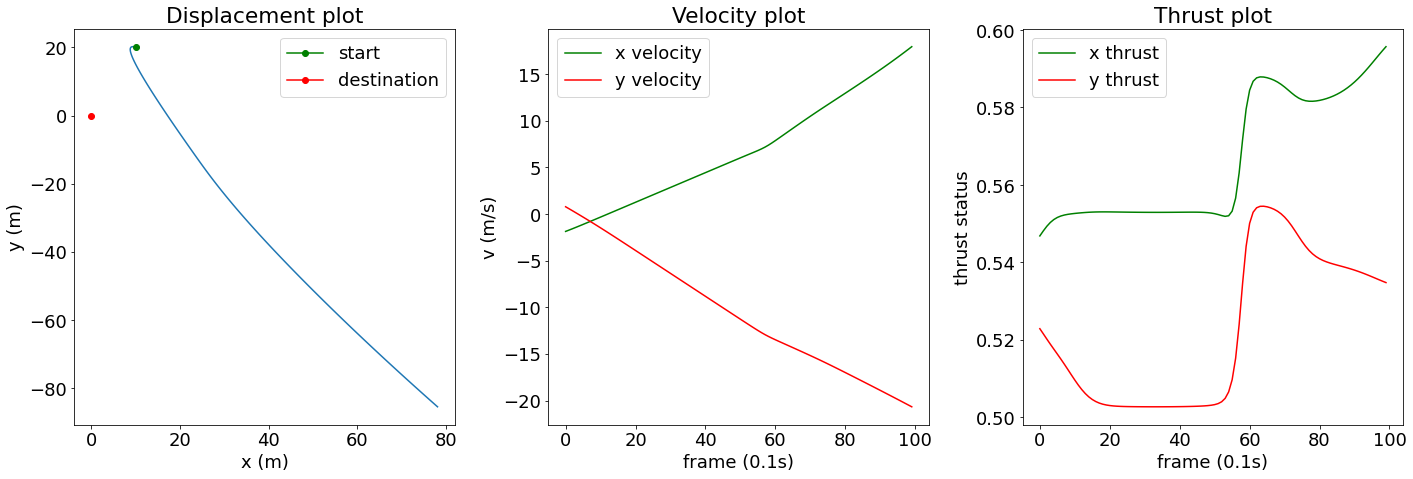

[2] loss: 7006.934
[3] loss: 2777.947
[4] loss: 97.332
[5] loss: 87.260
[6] loss: 78.162
[7] loss: 69.987
[8] loss: 62.503
[9] loss: 55.468
[10] loss: 48.359
[11] loss: 40.924


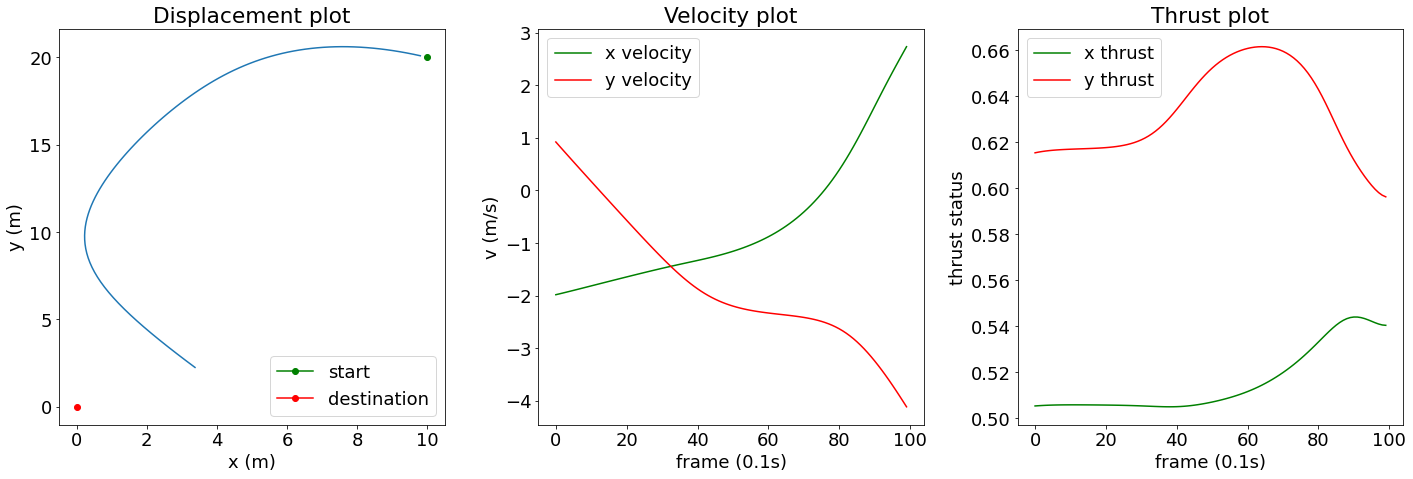

[12] loss: 33.289
[13] loss: 24.964
[14] loss: 498699.969
[15] loss: 396425.969
[16] loss: 70694.766
[17] loss: 18070.055
[18] loss: 9049.380
[19] loss: 4712.385
[20] loss: 3297.470
[21] loss: 2240.855


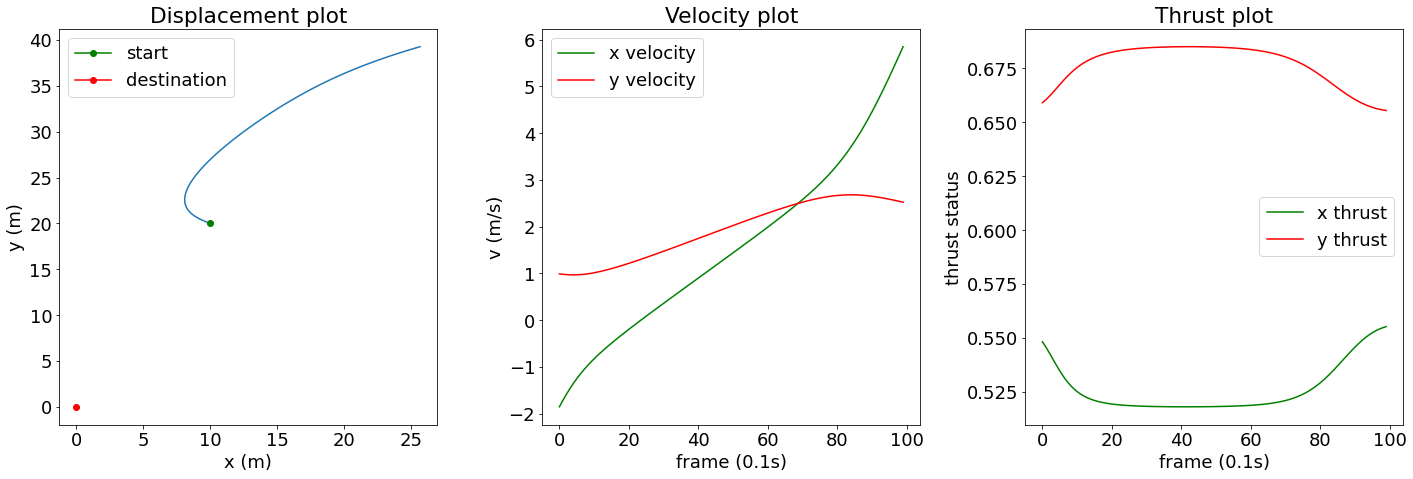

[22] loss: 1516.467
[23] loss: 1031.222
[24] loss: 708.052
[25] loss: 482.012
[26] loss: 326.447
[27] loss: 223.721
[28] loss: 155.386
[29] loss: 109.502
[30] loss: 78.356
[31] loss: 58.230


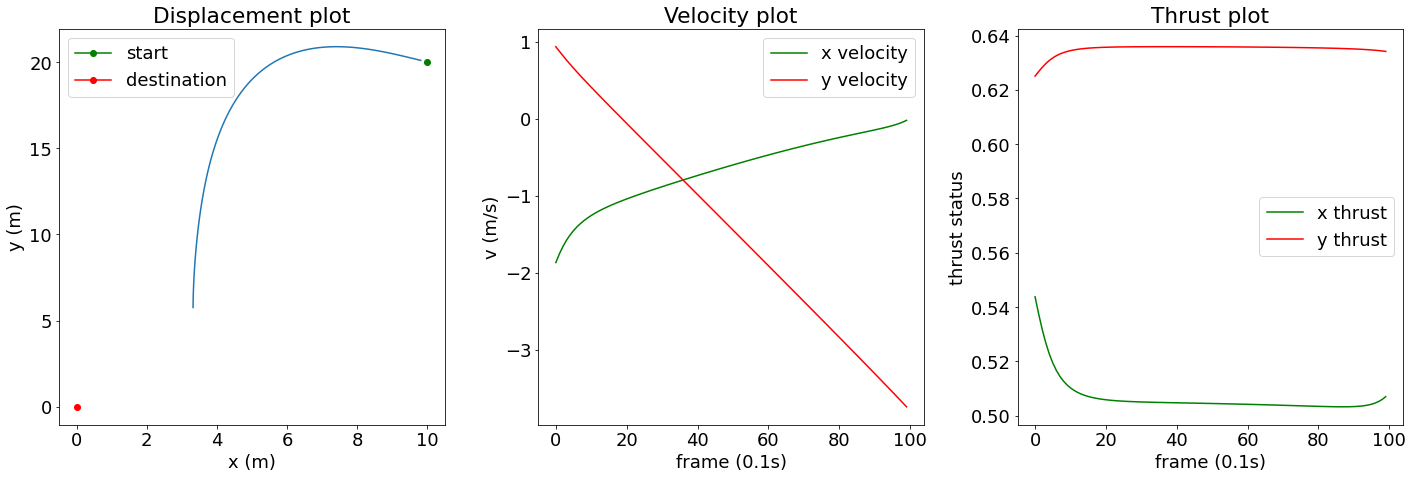

[32] loss: 46.802
[33] loss: 40.795
[34] loss: 37.798
[35] loss: 36.148
[36] loss: 35.133
[37] loss: 34.467
[38] loss: 34.016
[39] loss: 33.703
[40] loss: 33.481
[41] loss: 33.319


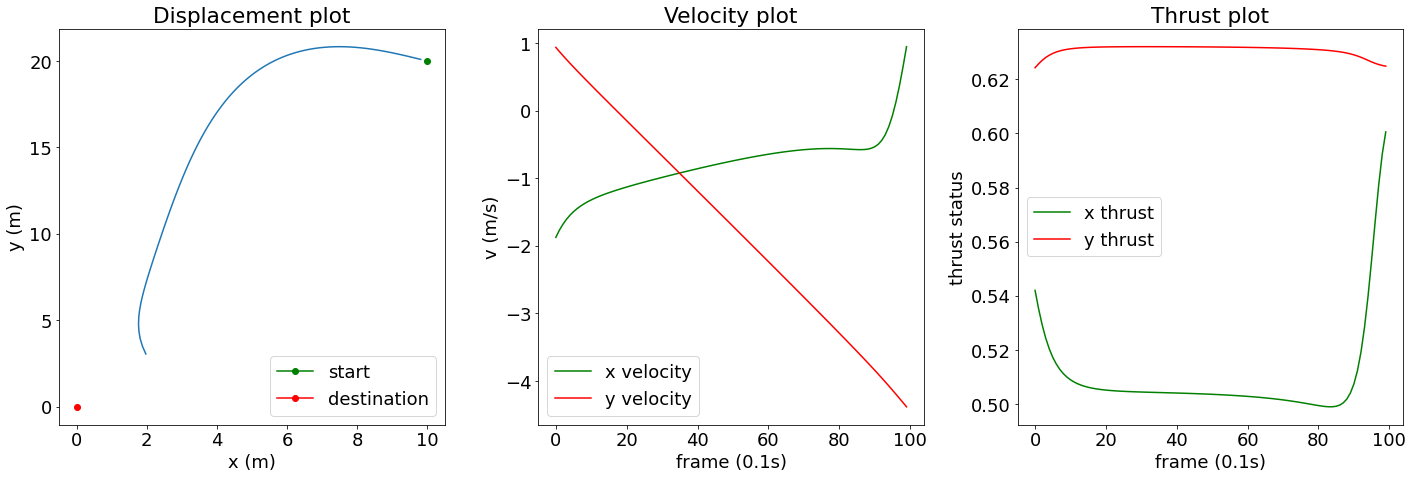

[42] loss: 33.199
[43] loss: 33.106
[44] loss: 33.033
[45] loss: 32.973
[46] loss: 32.924
[47] loss: 32.882
[48] loss: 32.845
[49] loss: 32.805
[50] loss: 32.749
[51] loss: 32.645


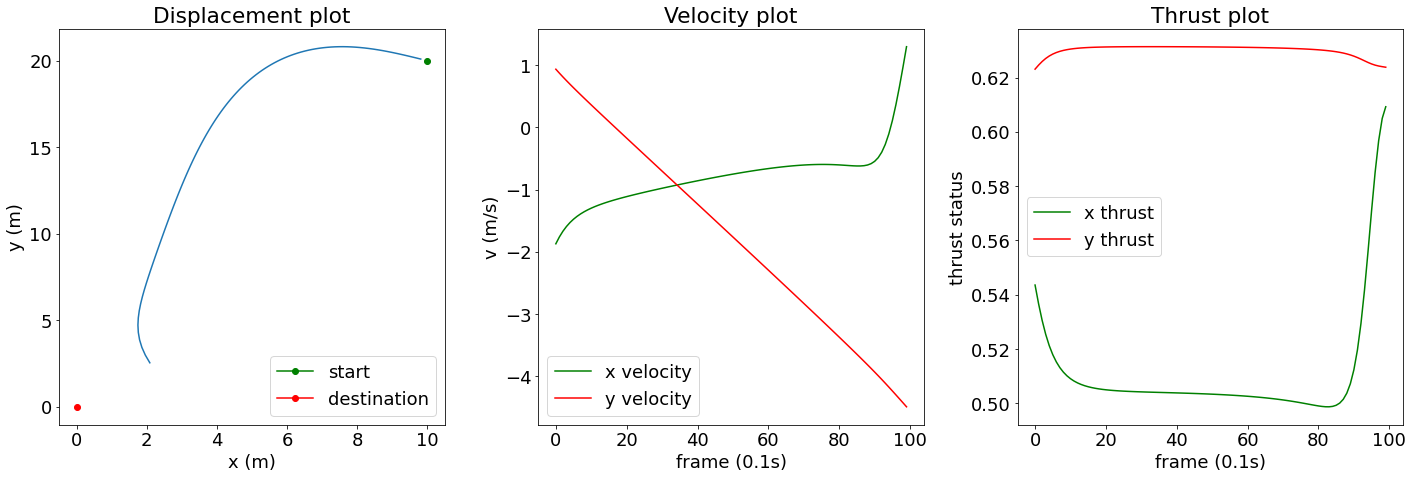

[52] loss: 32.405
[53] loss: 31.574
[54] loss: 30.089
[55] loss: 29.354
[56] loss: 28.669
[57] loss: 27.979
[58] loss: 27.328
[59] loss: 26.695
[60] loss: 26.036
[61] loss: 25.067


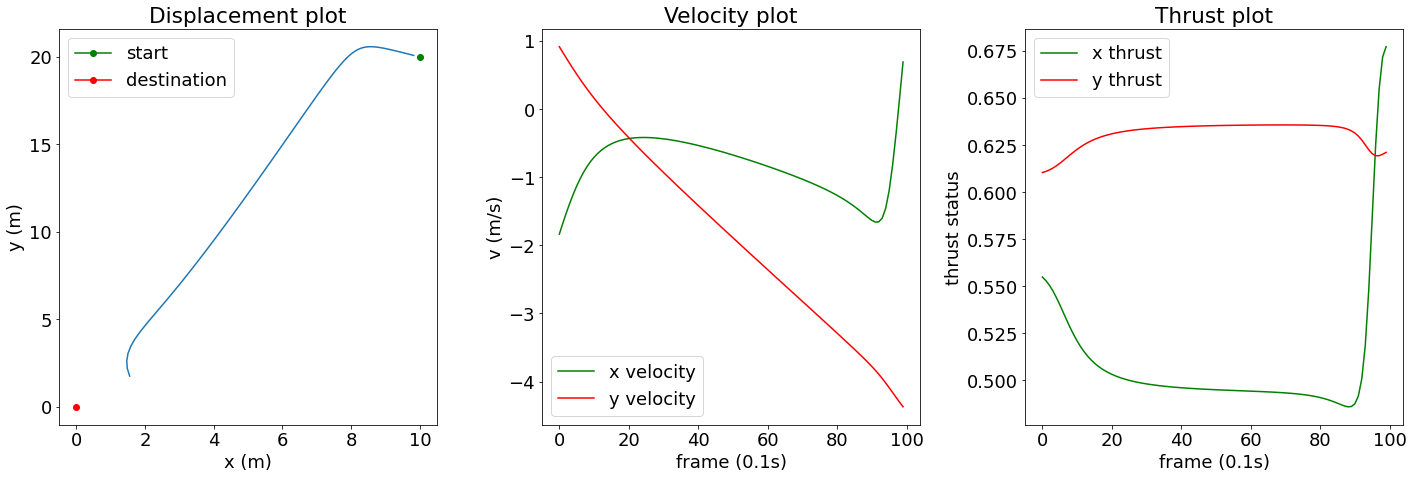

[62] loss: 24.022
[63] loss: 22.836
[64] loss: 21.273
[65] loss: 19.396
[66] loss: 17.454
[67] loss: 15.716
[68] loss: 14.258
[69] loss: 13.078
[70] loss: 12.055
[71] loss: 10.517


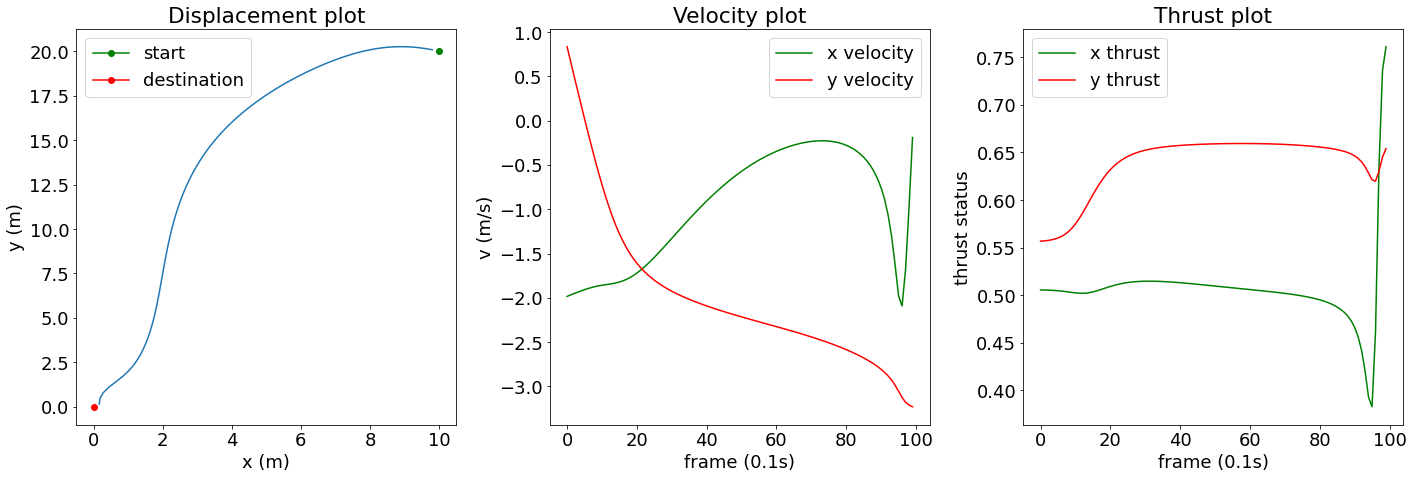

[72] loss: 8.779
[73] loss: 8.266
[74] loss: 7.987
[75] loss: 7.768
[76] loss: 7.605
[77] loss: 7.329
[78] loss: 7.124
[79] loss: 7.003
[80] loss: 6.793
[81] loss: 84.417


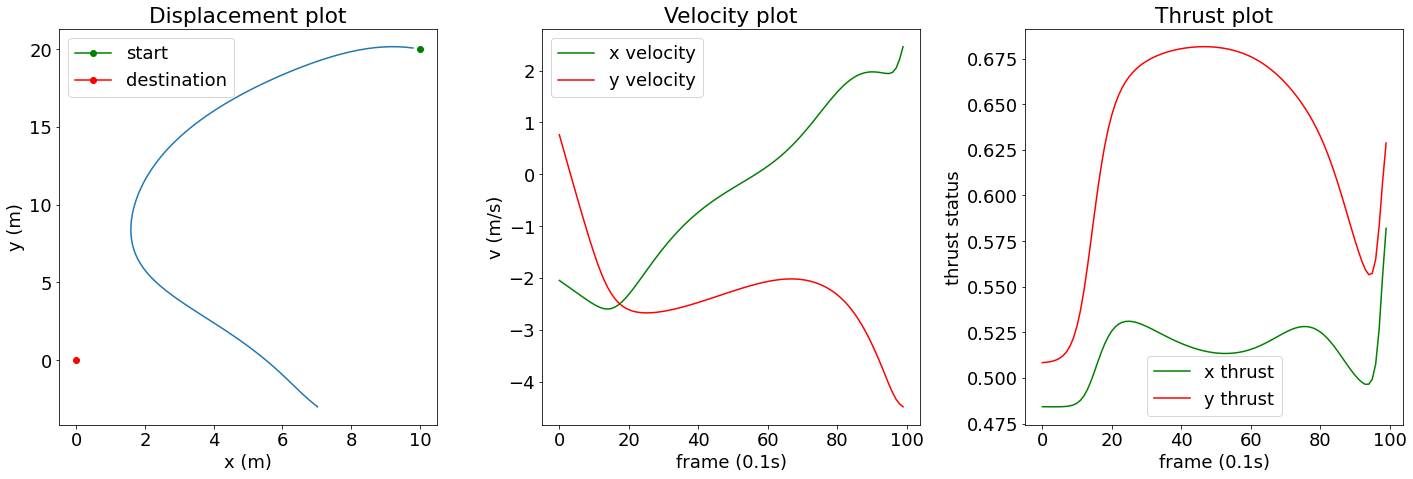

In [ ]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)
plt.rcParams.update({'font.size': 18})
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = -9.81  # m/s2, gravity constant
BOOST_ACCEL = 15.0  # m/s2, thrust constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action:
        action[0]: thrust in x direction. range (0, 1). 
                    1 means max thrust. 0 means no thrust.
        action[1]: thrust in y direction. range (0, 1).
                    0 means thrust to left.
                    0.5 means no thrust.
                    1 means thrust to right.
        
        states:
        state[0] = x
        state[1] = v_x
        state[2] = y
        state[3] = v_y
        """
        
        # Apply gravity       
        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust of x and y directions are calculated respectively
        thrust_x = action[0]*2.0-1.0
        thrust_y = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0 , 0., 0.]) * thrust_x
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0. , 0., 1.0]) * thrust_y
        
        # Update velocity, both gravity, thrust of x and y are used
        state = state + delta_state_x + delta_state_y + delta_state_gravity
        
        # Update state 
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 10 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        v_x = data[:, 1]
        y1 = data[:, 2]
        v_y = data[:, 3]
        tt = range(self.simulation.T)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_xx = data1[:, 0]
        thrust_yy = data1[:, 1]
        
        fig, ax = plt.subplots(1, 3, figsize=(20, 7))
        
        ax[0].plot(x1, y1)
        ax[0].plot(10, 20, '-ro', c='g', label='start')
        ax[0].plot(0, 0, '-ro', c='r', label='destination')
        ax[0].set_xlabel('x (m)')
        ax[0].set_ylabel('y (m)')
        ax[0].set(title='Displacement plot')
        ax[0].legend()
        
        ax[1].plot(tt, v_x, c='g', label='x velocity')
        ax[1].plot(tt, v_y, c='r', label='y velocity')
        ax[1].set_xlabel('frame (0.1s)')
        ax[1].set_ylabel('v (m/s)')
        ax[1].set(title='Velocity plot')
        ax[1].legend()
        
        ax[2].plot(tt, thrust_xx, c='g', label='x thrust')
        ax[2].plot(tt, thrust_yy, c='r', label='y thrust')
        ax[2].set_xlabel('frame (0.1s)')
        ax[2].set_ylabel('thrust status')
        ax[2].set(title='Thrust plot')
        ax[2].legend()
           
        fig.tight_layout()
        
        plt.show()

# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(81)  # solve the optimization problem